----

In [1]:
# imports
import pandas as pd; import missingno as msno; import matplotlib.pyplot as plt; import seaborn as sns;import numpy as np;import warnings
from sklearn import preprocessing; from scipy import stats

# settings
np.seterr(divide='warn', invalid='warn'); sns.set_style("whitegrid");warnings.filterwarnings('ignore')

-----

# Project: Bosch Manufacturing Line

__Author:__ [Ryan Harper](www.kimrharper.com) <br><br>
__Data Source:__ [Bosch Dataset via Kaggle](https://www.kaggle.com/c/bosch-production-line-performance/data) <br> <br>
__Background:__ Bosch is a home appliance and industrial tools manufacturing company. In 2017, Bosch supplied Kaggle.com with manufacturing data to promote a competition. The goal of the competition was to determine factors that influence whether or not the product passes the final response stage of manufacturing and to predict which products are likely to fail based on this manufacturing process.<br> <br>
__The Data:__ Early exploration of this data will use a subset of the big data provided by Bosch. The data is provided by [Hitesh, John, and Matthew via PDX Data Science Meetup](https://www.meetup.com/Portland-Data-Science-Group/events/257370691/). The data subset is divided into 2 groups of 3 files (3 training, 3 test). Each group has one csv file each for numerical features ('numeric'), dates ('date'), and the manufacturing path ('cat'). The data subset includes a larger percentage of products that failed the response test, but not much more is known about this subsampling method.<br><br>
__Assumptions:__ ID # represents a specific product and that there is only one product. The differences in assembly are due to customization and/or differences between lines.<br><br>
__Goal:__ Predict which products will fail the response test. <br><br>

## I. Exploratory Analysis

### A. Numerical Data

In [2]:
# import numerical data
mf_num_data = pd.read_csv('bosch_small_data/train_numeric.csv',low_memory=False)

As the data is extremely large, it is important to explore the structure of the data to get a feel for what is happening. The numerical data appears to be the most important, so I will start with examining the numerical data.

In [3]:
# show data with pandas
mf_num_data.head(2)

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,71,-0.167,-0.168,0.276,0.33,0.074,0.161,0.052,0.248,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


There are a lot of missing data and null (NaN) values. It is not obvious if this is due to recording errors (which I suspect is not the case), or if it is related to the structuring of the data. I need to continue visualizing the data.

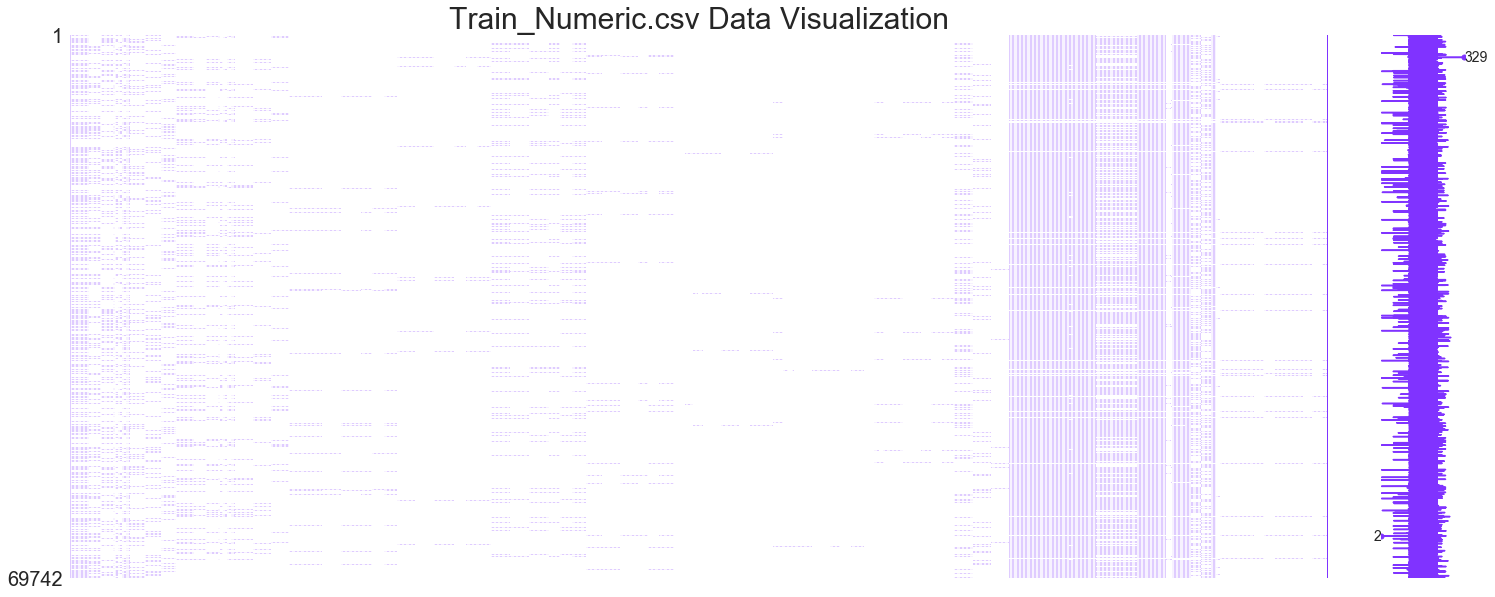

In [4]:
# visualize numerical data with missingno
msno.matrix(mf_num_data, color=(.5,.2,1))
plt.title('Train_Numeric.csv Data Visualization',size=30)
plt.show()

The graph above shows which values are included (purple) and which values are missing (white). The final column on the right side of the graph shows how many values are included in each row. Every row appears to have at most 20-30% of the columns filled in with values. This graph confirms that the data set is very sparse and reaffirms explanations of the data from the Kaggle site and from Hitesh's presentation on the data. 

In [5]:
# split the strings
columns_set = list(mf_num_data.columns)[1:-1]
breakup_strings = [i.split('_') for i in columns_set]

# store the values in separate containers
line_count = set([i[0] for i in breakup_strings[0:-1]])
station_count = set([i[1] for i in breakup_strings[0:-1]])
feature_count = set([i[2] for i in breakup_strings[0:-1]])

print('Unique lines: {}\nUnique Stations: {}\nUnique Feature Measurements: {}'.format(
    len(line_count),len(station_count),len(feature_count)))

Unique lines: 4
Unique Stations: 50
Unique Feature Measurements: 967


In [6]:
# function for calculating ratio of failures
def get_ratio(column):
    all_response = mf_num_data[[column,'Response']].dropna()['Response']
    return [column, all_response.sum()/len(all_response)]

# calculate ratio of failures for every columns
vals = [get_ratio(i) for i in mf_num_data.columns[1:-1]]

# sort values and push to df
sorted_corr = pd.DataFrame(vals).sort_values(by=[1],ascending=False)

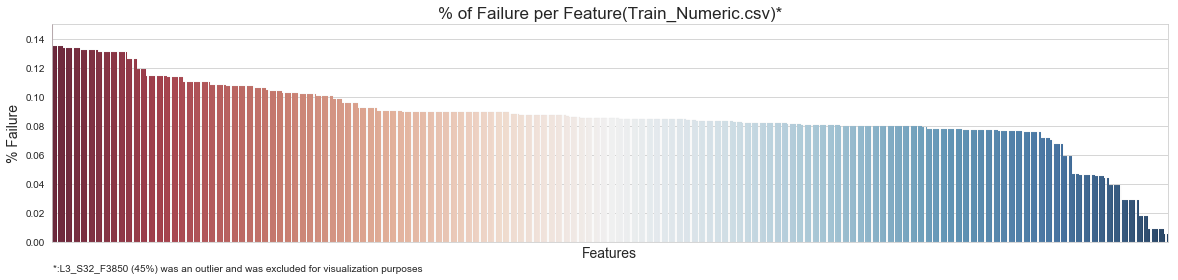

In [7]:
plt.figure(figsize=(20,4))
sns.barplot(x=0,y=1,data=sorted_corr,palette="RdBu",linewidth=.1,edgecolor=".8",orient='v')
plt.xticks([])
plt.xlabel('Features',size=14)
plt.ylabel('% Failure',size=14)
plt.ylim(0,.15)
plt.title('% of Failure per Feature (Train_Numeric.csv)*',size=17)
plt.text(1,-.02, '*:L3_S32_F3850 (45%) was an outlier and was excluded for visualization purposes')
plt.show()

### B. Timeseries Data

In [8]:
# Import date data
mf_date_data = pd.read_csv('bosch_small_data/train_date.csv',low_memory=False)

In [9]:
mf_date_data.head(4)

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263,Response
0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,71,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,86,922.90,922.90,922.90,922.90,922.90,922.90,922.90,922.90,922.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [10]:
def final_time(df,row_ind):
    time = df.iloc[row_ind,1:-1].dropna().iloc[-1]
    response = df.iloc[row_ind,-1]
    return time,response
# final_time(mf_date_data,31)

In [11]:
last_time =[]
for i in range(len(mf_date_data.iloc[:,1:-1])):
    try:
        lt, sc = final_time(mf_date_data,i)
        last_time.append(lt)
    except:
        last_time.append(0)
mf_date_data['final_time'] = last_time

In [12]:
time_series_plot = mf_date_data[['final_time','Response']]

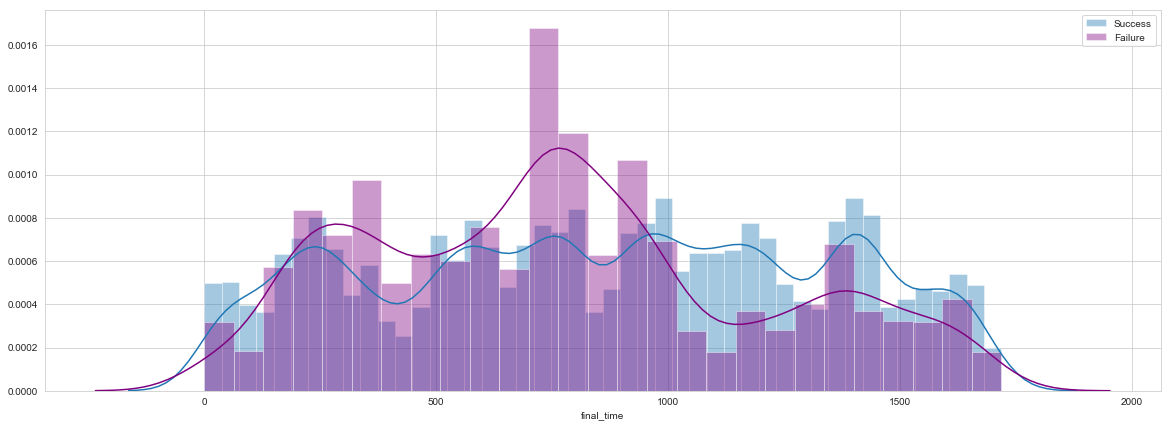

In [13]:
plt.figure(figsize=(20,7))
sns.distplot(time_series_plot['final_time'][time_series_plot['Response']==0])
sns.distplot(time_series_plot['final_time'][time_series_plot['Response']==1],color='purple')
plt.legend(['Success','Failure'])
plt.show()

### C. Graph/Network Data

In [16]:
# Import linking data
mf_cat_data = pd.read_csv('bosch_small_data/train_cat.csv',low_memory=False)

In [23]:
mf_cat_data.head(2)

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240,Response
0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [24]:
mf_cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69742 entries, 0 to 69741
Columns: 2142 entries, Id to Response
dtypes: float64(822), int64(1), object(1319)
memory usage: 1.1+ GB


In [26]:
mf_cat_data.iloc[23].dropna()

Id              865
L3_S29_F3317     T1
L3_S29_F3320     T1
L3_S29_F3323     T1
L3_S29_F3326     T1
L3_S29_F3329     T1
L3_S29_F3332     T1
L3_S29_F3335     T1
L3_S29_F3338     T1
L3_S29_F3341     T1
L3_S29_F3344     T1
L3_S29_F3347     T1
L3_S29_F3350     T1
L3_S29_F3353     T1
L3_S29_F3356     T1
L3_S29_F3359     T1
L3_S29_F3362     T1
L3_S29_F3364     T1
L3_S29_F3366     T1
L3_S29_F3369     T1
L3_S29_F3372     T1
L3_S29_F3375     T1
L3_S29_F3378     T1
L3_S29_F3381     T1
L3_S29_F3384     T1
L3_S29_F3387     T1
L3_S29_F3390     T1
L3_S29_F3392     T1
L3_S29_F3394     T1
L3_S29_F3397     T1
               ... 
L3_S29_F3414     T1
L3_S29_F3416     T1
L3_S29_F3418     T1
L3_S29_F3420     T1
L3_S29_F3423     T1
L3_S29_F3426     T1
L3_S29_F3429     T1
L3_S29_F3432     T1
L3_S29_F3435     T1
L3_S29_F3438     T1
L3_S29_F3441     T1
L3_S29_F3444     T1
L3_S29_F3446     T1
L3_S29_F3448     T1
L3_S29_F3451     T1
L3_S29_F3454     T1
L3_S29_F3457     T1
L3_S29_F3460     T1
L3_S29_F3463     T1


## II. Statistical Analysis

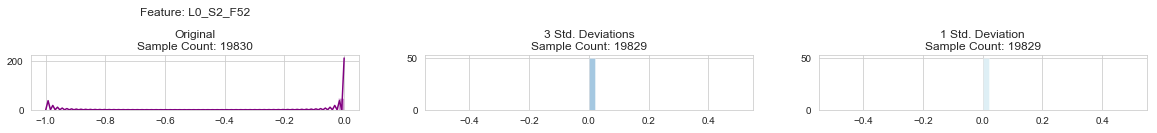

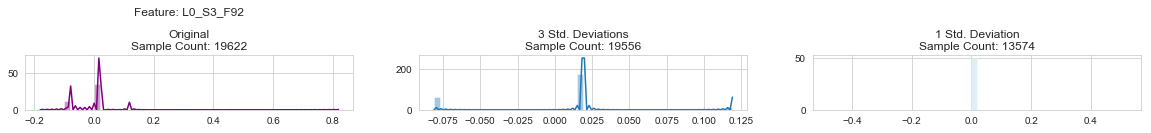

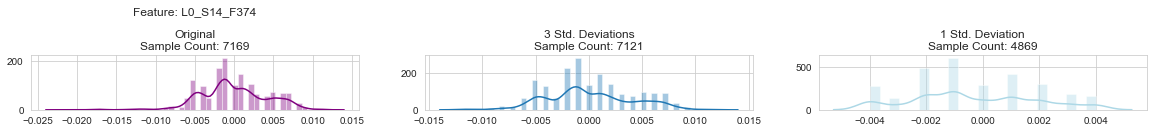

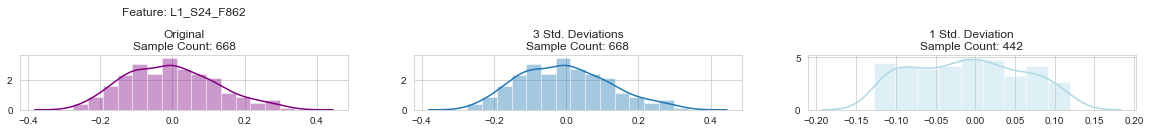

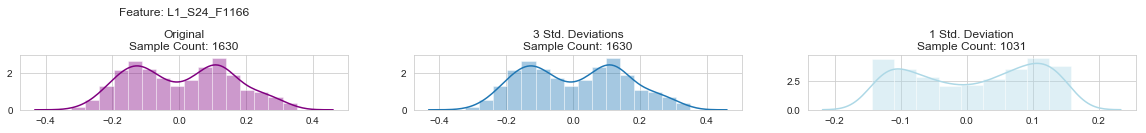

In [14]:
def plot_dist(df, col_index):
    c = df.columns[col_index]
    s_old = df[c].dropna()
    s_3 = df[c][np.abs(df[c]-df[c].mean()) <= (3*df[c].std())]
    s_1 = df[c][np.abs(df[c]-df[c].mean()) <= (1*df[c].std())]
    
    plt.figure(figsize=(20,1))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
    
    plt.subplot(1, 3, 1)
    plt.title('Feature: {}\n\nOriginal\nSample Count: {}'.format(c,len(df[c].dropna())))
    sns.distplot(s_old,color='purple')
    plt.xlabel('')
    
    plt.subplot(1, 3, 2)
    plt.title('3 Std. Deviations\nSample Count: {}'.format(len(s_3.dropna())))
    sns.distplot(s_3)
    plt.xlabel('')

    plt.subplot(1, 3, 3)
    plt.title('1 Std. Deviation\nSample Count: {}'.format(len(s_1.dropna())))
    sns.distplot(s_1,color='lightblue')
    plt.xlabel('')
    
[plot_dist(mf_num_data,i) for i in [20,30,100,200,260]];

In [15]:
# finds 'nonnormal distributions'
nonnormal = []
for i,c in enumerate(columns_set):
    k,p = stats.normaltest(mf_num_data[c].dropna().values)
    if p >.001:
        nonnormal.append([c,i,p,k])           